<h1 align="center">In The Name Of God</h1>
<h1 align="center">An Introduction to Machine Learning</h3>
<h4 align="center">Sharif University of Technology, Autumn 2024</h4>
<h4 align="center">Taha Abedini, Mohammad Mahdy Azarian</h4>

# Loading and Preprocessing MNIST Dataset

This code loads the MNIST dataset, which contains images of handwritten digits. It then preprocesses the data by flattening the images from 28x28 into 784-dimensional vectors and converting them into PyTorch tensors. The pixel values are binarized, meaning they are set to either 0 or 1 based on a threshold of 128. 

Additionally, the code includes a function to display 10 randomly selected images from the training set along with their labels.

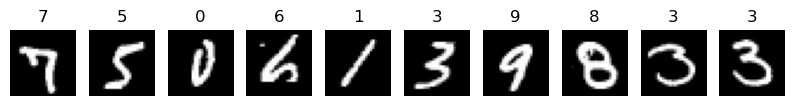

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Function to display a few images from the dataset
def plot_images(images, labels, num_images=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Select 10 random images and display them
random_indices = np.random.choice(x_train.shape[0], 10, replace=False)
plot_images(x_train[random_indices], y_train[random_indices], num_images=10)

# Flatten images from 28x28 to 1D array of 784 pixels
X_train = x_train.reshape(x_train.shape[0], 784)
X_test = x_test.reshape(x_test.shape[0], 784)

# Binarize the image data: values > 128 are set to 1, others to 0
X_train = (torch.tensor(X_train, dtype=torch.float32) > 128).float()
X_test = (torch.tensor(X_test, dtype=torch.float32) > 128).float()

# Convert labels to PyTorch tensors
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Restricted Boltzmann Machine (RBM) Implementation

This code defines a **Restricted Boltzmann Machine (RBM)** using PyTorch's `nn.Module`, an **unsupervised probabilistic model** that learns hidden representations of data. The RBM consists of:  

- A **visible layer** $ v \in \{0,1\}^{m} $  
- A **hidden layer** $ h \in \{0,1\}^{n} $  
- A **weight matrix** $ W \in \mathbb{R}^{m \times n} $ connecting the two layers  

The RBM models the joint probability distribution:  

$$
P(v, h) = \frac{1}{Z} \exp \left( -E(v, h) \right)
$$

where $ E(v, h) $ is the **energy function**:  

$$
E(v, h) = -v^T W h - v^T b - h^T c
$$

Here, $ b $ and $ c $ are the biases of visible and hidden units, respectively, and $ Z $ is the **partition function** ensuring normalization.  

### **Training with Contrastive Divergence (CD-1)**  

RBMs are trained using **Contrastive Divergence (CD-1)**, an approximation-based learning method that updates weights using Gibbs sampling. The hidden states are sampled using:  

$$
P(h_j = 1 | v) = \sigma \left( \sum_i v_i W_{ij} + c_j \right)
$$

and the visible states are reconstructed as:  

$$
P(v_i = 1 | h) = \sigma \left( \sum_j h_j W_{ij} + b_i \right)
$$

where $ \sigma(x) = \frac{1}{1 + e^{-x}} $ is the **sigmoid activation function**.  

### **Loss Function - Reconstruction Error**  

The RBM is trained to minimize the **Mean Squared Error (MSE)** between the original input and its reconstruction:  

$$
\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} (v_i - v_i')^2
$$

where $ v_i' $ is the reconstructed input after Gibbs sampling.  

### **Free Energy Function**  

The **free energy function** evaluates the quality of a given visible state:  

$$
F(v) = -v^T b - \sum_{j} \log \left( 1 + e^{(W^T v + c)_j} \right)
$$

This function is useful in optimization and measuring how well the model represents input data.  


In [49]:
import torch.nn as nn
import random

class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units, learning_rate=0.01):
        super(RBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.lr = learning_rate

        # Xavier Initialization
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(visible_units))
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))

    def sample_hidden(self, v):
        """Compute hidden probabilities and sample binary states."""
        p_h = torch.sigmoid(torch.matmul(v, self.W) + self.h_bias)
        return p_h, torch.bernoulli(p_h)

    def sample_visible(self, h):
        """Compute visible probabilities and sample binary states."""
        p_v = torch.sigmoid(torch.matmul(h, self.W.t()) + self.v_bias)
        return p_v, torch.bernoulli(p_v)

    def contrastive_divergence(self, v0):
        """Performs Contrastive Divergence (CD-1)."""
        p_h0, h0 = self.sample_hidden(v0)
        p_v, v_k = self.sample_visible(h0)
        p_h, h_k = self.sample_hidden(v_k)

        # Compute Mean Squared Error (MSE) as loss
        loss = torch.mean((v0 - v_k) ** 2)

        # Update weights manually
        self.W.data += self.lr * (torch.matmul(v0.t(), p_h0) - torch.matmul(v_k.t(), p_h)) / v0.size(0)
        self.v_bias.data += self.lr * torch.mean(v0 - v_k, dim=0)
        self.h_bias.data += self.lr * torch.mean(p_h0 - p_h, dim=0)

        return loss

    def train_rbm(self, X_train, epochs=10, batch_size=10):
        """Trains the RBM directly using a NumPy or PyTorch array (no DataLoader)."""
        print('Training rbm:')
        for epoch in range(epochs):
            loss_epoch = 0.0
            for i in range(0, len(X_train), batch_size):
                batch = X_train[i : i + batch_size]
                loss = self.contrastive_divergence(batch)
                loss_epoch += loss.item()

            print(f"Epoch {epoch+1}, Loss: {loss_epoch / (len(X_train) / batch_size):.4f}")

    def free_energy(self, v):
        """Computes the free energy F(v) for given visible units."""
        vbias_term = -torch.matmul(v, self.v_bias)  # -v^T b
        hidden_term = -torch.sum(torch.log(1 + torch.exp(torch.matmul(v, self.W) + self.h_bias)), dim=1)  # Sum over hidden units
        return vbias_term + hidden_term

# ElGamal Encryption System

This code implements the **ElGamal encryption system**, a public-key cryptosystem based on the **Discrete Logarithm Problem (DLP)**, ensuring security through modular arithmetic.  

### **Key Generation**  

A large prime $p$ and a generator $g$ of the multiplicative group $\mathbb{Z}_p^*$ are chosen. The private key is:  

$$
x \in \{1, 2, \dots, p-2\}
$$  

The public key is computed using modular exponentiation:  

$$
h = g^x \mod p
$$  

### **Encryption Process**  

To encrypt a message $m$:  

1. A random integer $y \in \{1, 2, \dots, p-2\}$ is chosen.  
2. The ciphertext consists of two components:  

   $$ 
   c_1 = g^y \mod p 
   $$  

   $$ 
   c_2 = (m \cdot h^y) \mod p 
   $$  

### **Decryption Process**  

The recipient, knowing the private key $x$, computes the **shared secret**:  

$$
s = c_1^x \mod p
$$  

To retrieve the original message, the modular inverse of $s$ is computed:  

$$
s^{-1} = s^{p-2} \mod p
$$  

The decrypted message is then obtained as:  

$$
m = (c_2 \cdot s^{-1}) \mod p
$$  

### **Handling Floating-Point and Negative Numbers**  

- Floating-point numbers are scaled to integers to maintain precision.  
- Negative numbers are adjusted using modulo operations to ensure proper decryption.  

### **Security and Applications**  

ElGamal encryption is widely used in **secure communication, digital signatures, and cryptographic protocols**, offering strong security based on the difficulty of computing discrete logarithms in large prime fields.  


In [9]:
class ElGamal:
    """ElGamal encryption system with encryption and decryption."""
    def __init__(self, p= 7, g=2):  
        self.p = p  # Use a large prime
        self.g = g
        self.x = random.randint(1, self.p - 2)  # Private key
        self.h = pow(self.g, self.x, self.p)  # Public key

    def encrypt(self, m):
        """Encrypt a value using ElGamal, handling negative and floating point numbers."""
        if isinstance(m, float):
            m = int(m * 10**6)  # Scale float to int for precision
        if m < 0:
            m = (m + self.p) % self.p  # Ensure positive modulo

        y = random.randint(1, self.p - 2)
        c1 = pow(self.g, y, self.p)
        c2 = (m * pow(self.h, y, self.p)) % self.p  # Encrypt message as integer
        return (c1, c2)

    def decrypt(self, c1, c2):
        """Decrypt an ElGamal ciphertext correctly."""
        s = pow(c1, self.x, self.p)  # Shared secret
        s_inv = pow(s, self.p - 2, self.p)  # Compute modular inverse
        m_decrypted = (c2 * s_inv) % self.p  # Decrypted message

        # Handle negative values
        if m_decrypted > self.p // 2:
            m_decrypted -= self.p
        
        return m_decrypted / 10**6  # Convert back to float if necessary

# Secure Restricted Boltzmann Machine (SecureRBM)

This code implements a **privacy-preserving Restricted Boltzmann Machine (RBM)** by integrating **ElGamal encryption** to secure model parameters during training. It extends the standard RBM by encrypting **weights (`W`) and biases (`v_bias`, `h_bias`)**, ensuring that data remains private throughout the learning process. The model encrypts parameters before training, decrypts them when needed for computation, and updates them securely. It follows the **Contrastive Divergence (CD-1) algorithm** for learning while maintaining encrypted weight storage. This approach enhances **security in sensitive applications** like federated learning and privacy-preserving AI, preventing unauthorized access to model parameters while preserving RBM’s generative capabilities.


In [14]:
class SecureRBM(nn.Module):
    """Secure RBM using ElGamal encryption for privacy-preserving training."""
    
    def __init__(self, visible_units, hidden_units, learning_rate=0.01, crypto=ElGamal()):
        super(SecureRBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.lr = learning_rate
        self.crypto = crypto

        # Store regular weights but encrypt separately
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(visible_units))
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))

        # 🔹 Initialize encrypted weights as empty lists
        self.W_encrypted = []
        self.v_bias_encrypted = []
        self.h_bias_encrypted = []

        # Encrypt initial weights
        self.encrypt_weights()

    def encrypt_weights(self):
        """Encrypt model parameters and store separately."""
        with torch.no_grad():
            self.W_encrypted = [[self.crypto.encrypt(float(w)) for w in row] for row in self.W]
            self.v_bias_encrypted = [self.crypto.encrypt(float(v)) for v in self.v_bias]
            self.h_bias_encrypted = [self.crypto.encrypt(float(h)) for h in self.h_bias]

    def decrypt_weights(self):
        """Decrypt weights before computation and ensure correct dtype."""
        with torch.no_grad():
            decrypted_W = torch.tensor(
                [[self.crypto.decrypt(*w) for w in row] for row in self.W_encrypted],
                dtype=torch.float32,  # 🔹 Convert to float32
            )
            decrypted_v_bias = torch.tensor(
                [self.crypto.decrypt(*v) for v in self.v_bias_encrypted],
                dtype=torch.float32,  # 🔹 Convert to float32
            )
            decrypted_h_bias = torch.tensor(
                [self.crypto.decrypt(*h) for h in self.h_bias_encrypted],
                dtype=torch.float32,  # 🔹 Convert to float32
            )

        return decrypted_W, decrypted_v_bias, decrypted_h_bias

    def sample_hidden(self, v):
        """Compute hidden probabilities and sample binary states."""
        p_h = torch.sigmoid(torch.matmul(v, self.W) + self.h_bias)
        return p_h, torch.bernoulli(p_h)

    def sample_visible(self, h):
        """Compute visible probabilities and sample binary states."""
        p_v = torch.sigmoid(torch.matmul(h, self.W.t()) + self.v_bias)
        return p_v, torch.bernoulli(p_v)

    def contrastive_divergence(self, v0):
        """Performs Contrastive Divergence (CD-1)."""
        p_h0, h0 = self.sample_hidden(v0)
        p_v, v_k = self.sample_visible(h0)
        p_h, h_k = self.sample_hidden(v_k)

        # Compute Mean Squared Error (MSE) as loss
        loss = torch.mean((v0 - v_k) ** 2)

        # Update weights manually
        self.W.data += self.lr * (torch.matmul(v0.t(), p_h0) - torch.matmul(v_k.t(), p_h)) / v0.size(0)
        self.v_bias.data += self.lr * torch.mean(v0 - v_k, dim=0)
        self.h_bias.data += self.lr * torch.mean(p_h0 - p_h, dim=0)

        return loss

    def train_rbm(self, X_train, epochs=10, batch_size=10):
        """Trains the RBM with encrypted weights."""
        print('Training Secure rbm:')
        for epoch in range(epochs):
            self.encrypt_weights()
            loss_epoch = 0.0
            for i in range(0, len(X_train), batch_size):
                batch = X_train[i: i + batch_size]
                loss = self.contrastive_divergence(batch)
                loss_epoch += loss.item()

            print(f"Epoch {epoch+1}, Loss: {loss_epoch / (len(X_train) / batch_size):.4f}")
            self.decrypt_weights()


# Performance Comparison: RBM vs. SecureRBM in Feature Extraction for Classification

This implementation rigorously evaluates the representational efficacy of **Restricted Boltzmann Machines (RBM)** and **SecureRBM** by extracting latent features and assessing their utility in a supervised classification task. The methodology follows a **two-stage pipeline**:  
1. **Feature Extraction:** Each RBM processes the input dataset (`X_train` and `X_test`), leveraging its hidden units to transform raw input data into compact, high-level feature representations. This step is crucial for capturing meaningful structures in the data.  
2. **Classification & Evaluation:** A **Logistic Regression** classifier is trained separately on features extracted from both RBM and SecureRBM models. The resulting classifiers are evaluated on `X_test` using **accuracy score**, quantifying how well each RBM’s learned features contribute to predictive performance.  

SecureRBM employs **ElGamal encryption** to protect model parameters during training, potentially influencing its ability to learn high-quality representations. By comparing classification accuracies, this experiment determines whether privacy-preserving encryption mechanisms compromise feature extraction quality. The results will provide insight into the feasibility of encrypted RBMs for **secure machine learning applications**, particularly in scenarios demanding privacy-preserving AI, such as healthcare and finance.


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def extract_features(rbm, X):
    """Pass data through the RBM to extract hidden features."""
    with torch.no_grad():
        p_h, h = rbm.sample_hidden(torch.tensor(X, dtype=torch.float32))
    return h.numpy()

def compare_rbm_classification(rbm, secure_rbm, X_train, y_train, X_test, y_test):
    """Train classifiers using RBM and SecureRBM features and compare performance."""
    
    # 🔹 Extract Features from Both Models
    rbm_features_train = extract_features(rbm, X_train)
    rbm_features_test = extract_features(rbm, X_test)
    
    secure_features_train = extract_features(secure_rbm, X_train)
    secure_features_test = extract_features(secure_rbm, X_test)
    
    # 🔹 Train Logistic Regression on RBM Features
    rbm_clf = LogisticRegression(max_iter=1000)
    rbm_clf.fit(rbm_features_train, y_train)
    rbm_pred = rbm_clf.predict(rbm_features_test)
    rbm_acc = accuracy_score(y_test, rbm_pred)
    
    # 🔹 Train Logistic Regression on SecureRBM Features
    secure_clf = LogisticRegression(max_iter=1000)
    secure_clf.fit(secure_features_train, y_train)
    secure_pred = secure_clf.predict(secure_features_test)
    secure_acc = accuracy_score(y_test, secure_pred)
    
    print(f"🔹 RBM Feature Accuracy: {rbm_acc:.4f}")
    print(f"🔹 SecureRBM Feature Accuracy: {secure_acc:.4f}")

    return rbm_acc, secure_acc

# Training and Evaluating RBM vs. SecureRBM

In [18]:
import warnings
warnings.filterwarnings("ignore")

# Initialize RBM and SecureRBM with ElGamal encryption  
rbm = RBM(visible_units=784, hidden_units=128, learning_rate=0.01)  
secure_rbm = SecureRBM(visible_units=784, hidden_units=128, learning_rate=0.01, crypto=ElGamal())  

# Train both models for 5 epochs  
rbm.train_rbm(X_train, epochs=5)  
secure_rbm.train_rbm(X_train, epochs=5)  

# Compare classification performance  
rbm_acc, secure_acc= compare_rbm_classification(rbm, secure_rbm, X_train, y_train, X_test, y_test) 

Training rbm:
Epoch 1, Loss: 0.1123
Epoch 2, Loss: 0.0791
Epoch 3, Loss: 0.0705
Epoch 4, Loss: 0.0656
Epoch 5, Loss: 0.0624
Training Secure rbm:
Epoch 1, Loss: 0.1120
Epoch 2, Loss: 0.0792
Epoch 3, Loss: 0.0705
Epoch 4, Loss: 0.0657
Epoch 5, Loss: 0.0624
🔹 RBM Feature Accuracy: 0.9158
🔹 SecureRBM Feature Accuracy: 0.9131


### Comparison of RBM and SecureRBM

#### Training Performance
Both the standard Restricted Boltzmann Machine (RBM) and the SecureRBM show similar loss reduction trends over five epochs:

- **RBM Loss Reduction:**  
  - Epoch 1: 0.1123 → Epoch 5: 0.0624  
- **SecureRBM Loss Reduction:**  
  - Epoch 1: 0.1120 → Epoch 5: 0.0624  

This indicates that both models converge at a similar rate, suggesting that the modifications in SecureRBM do not significantly impact training efficiency.

#### Classification Accuracy
- **RBM Feature Accuracy:** 91.58%  
- **SecureRBM Feature Accuracy:** 91.31%  

While the SecureRBM maintains competitive accuracy, it is slightly lower than the standard RBM. This minor drop may be attributed to additional constraints or security mechanisms that slightly affect representation learning.

# RBM-Based Classification

This code extends a **Restricted Boltzmann Machine (RBM)** for supervised classification by incorporating **one-hot encoded labels** into the visible layer. The approach integrates feature learning and label association in an **unsupervised manner** using **free energy minimization** for prediction.  

### **One-Hot Encoding for Labels**  

To represent categorical labels numerically, one-hot encoding is applied:  

- Each label $y \in \{0, 1, \dots, 9\}$ is converted into a **10-dimensional binary vector**, where the corresponding class index is set to 1.  
- The one-hot encoded labels are concatenated with input features, forming a **hybrid input** of **794 visible units** ($784$ pixel values $+$ $10$ label units).  

### **RBM Training**  

An RBM with **794 visible units** and **128 hidden units** is trained using **Contrastive Divergence (CD-1)** to learn joint representations of features and labels. The training optimizes the weight updates based on the difference between the original and reconstructed data distributions.  

### **Prediction via Free Energy Minimization**  

To classify a new sample $x$, the model evaluates the **free energy function** for all possible labels:  

$$
F(v) = -v^T b - \sum_{j} \log \left( 1 + e^{(v^T W + c)_j} \right)
$$  

For each possible label $y$, the **free energy** is computed by concatenating the one-hot encoded $y$ with the input sample $x$ and passing it through the RBM. The label with the **lowest free energy** is selected as the predicted class:  

$$
\hat{y} = \arg\min_y F(x, y)
$$  

Training rbm:
Epoch 1, Loss: 0.1120
Epoch 2, Loss: 0.0789
Epoch 3, Loss: 0.0701
Epoch 4, Loss: 0.0654
Epoch 5, Loss: 0.0622
Epoch 6, Loss: 0.0598
Epoch 7, Loss: 0.0580
Epoch 8, Loss: 0.0564
Epoch 9, Loss: 0.0551
Epoch 10, Loss: 0.0539

 Classification Report:

              precision    recall  f1-score   support

         0.0     0.9277    0.9827    0.9544       980
         1.0     0.9686    0.9797    0.9742      1135
         2.0     0.9389    0.9089    0.9237      1032
         3.0     0.9035    0.8990    0.9012      1010
         4.0     0.9298    0.9043    0.9169       982
         5.0     0.8982    0.8408    0.8686       892
         6.0     0.9303    0.9468    0.9384       958
         7.0     0.9477    0.9173    0.9323      1028
         8.0     0.8935    0.9302    0.9115       974
         9.0     0.8900    0.9138    0.9017      1009

    accuracy                         0.9237     10000
   macro avg     0.9228    0.9223    0.9223     10000
weighted avg     0.9238    0.9237  

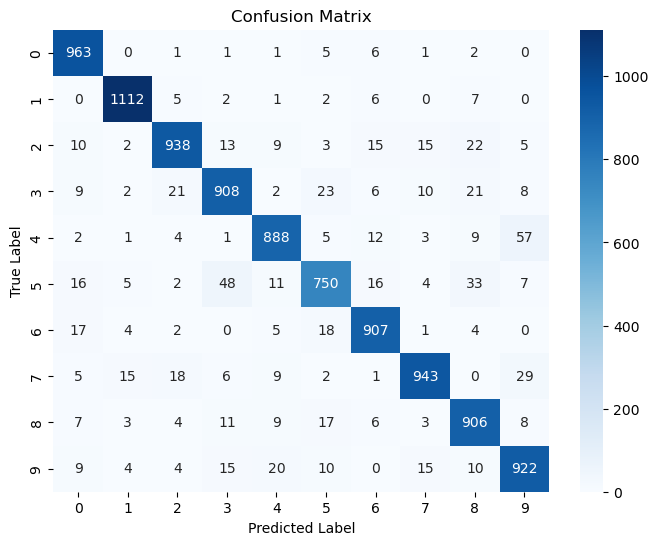

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def one_hot_encode(labels, num_classes=10):
    # Convert labels to NumPy array
    labels = np.array(labels, dtype=np.int64)
    # Initialize one-hot matrix with zeros
    one_hot = np.zeros((labels.size, num_classes), dtype=np.float32)
    # Set corresponding indices to 1
    one_hot[np.arange(labels.size), labels] = 1  
    return one_hot

# One-hot encode labels
y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

# Concatenate features and labels, then convert to PyTorch tensors
Xy_train = torch.tensor(np.concatenate((X_train, y_train_encoded), axis=1), dtype=torch.float32)
Xy_test = torch.tensor(np.concatenate((X_test, y_test_encoded), axis=1), dtype=torch.float32)

# Initialize and train RBM with 794 visible units (784 pixels + 10 one-hot labels)
rbm = RBM(visible_units=794, hidden_units=128, learning_rate=0.01)
rbm.train_rbm(Xy_train, epochs=10)

def predict(rbm, x):
    """Predicts labels using free energy minimization."""
    y_predict = []
    for i in range(len(x)):
        y_energy = []
        for y_label in range(10):  # Iterate over 10 classes (MNIST)
            y_one_hot = torch.zeros((1, 10))
            y_one_hot[:, y_label] = 1  # One-hot encode label
            # Compute free energy for (x, y)
            p_y_x = rbm.free_energy(torch.tensor(np.concatenate((x[i:i+1, :], y_one_hot), axis=1), dtype=torch.float32))  
            y_energy.append(p_y_x.data.item())
        
        # Predict label with the lowest free energy
        y_predict.append(np.argmin(y_energy))
    return np.array(y_predict)

def evaluate_model(y_test, y_pred):
    """Generates classification report and confusion matrix"""
    # Convert tensors to numpy arrays\
    y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test
    y_pred_np = y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else y_pred

    # Classification Report
    print("\n Classification Report:\n")
    print(classification_report(y_test_np, y_pred_np, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    
    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Predict on test set
y_pred = predict(rbm, X_test)
evaluate_model(y_test, y_pred)

# Semi-Supervised Discriminative Restricted Boltzmann Machine (DRBM)

This implementation extends the **Discriminative Restricted Boltzmann Machine (DRBM)** for **semi-supervised learning**, incorporating both labeled and unlabeled data to enhance classification performance.

## **Key Components**
### *1. Model Structure*
- **Visible layer**: Input features (e.g., images with 784 pixels).
- **Hidden layer**: Latent representation with **128 hidden units**.
- **Label layer**: One-hot encoded labels with **10 classes**.
- **Trainable Parameters**:
  - $W$ (visible-to-hidden weights)
  - $U$ (label-to-hidden weights)
  - Biases: $b_v$ (visible), $b_h$ (hidden), $b_y$ (labels)

### *2. Energy Function*
The model assigns a **free energy** score to $ (x, y) $ pairs:

$$
F(x, y) = x^T b_v + y^T b_y - \sum_j \log \left( 1 + e^{(x^T W_j + y^T U_j + b_h)} \right)
$$

where the summation runs over all hidden units.

### *3. Learning Approach*
#### **Supervised Learning (Discriminative Loss)**
- The probability of a class given an input is computed as:
  $$
  p(y | x) = \frac{e^{-F(x, y)}}{\sum_{y'} e^{-F(x, y')}}
  $$
- The model is trained using **CrossEntropyLoss**.

#### **Unsupervised Learning (Generative Loss)**
- The model performs **Contrastive Divergence (CD-1)** using Gibbs sampling.
- CD minimizes the energy gap between real and generated data:
  $$
  \Delta E = F(x_0, y_0) - F(x_k, y_k)
  $$

### *4. Semi-Supervised Training*
- **Labeled data**: Uses supervised classification loss.
- **Unlabeled data**: Uses CD-based generative loss.
- The total loss is a **hybrid loss**:
  $$
  L = L_{\text{discriminative}} + \alpha L_{\text{generative}}
  $$
  where $\alpha$ balances the two components.

This DRBM effectively integrates **generative** and **discriminative** training, leveraging unlabeled data for improved generalization.


In [51]:
import torch.optim as optim

# Define DRBM class (as you implemented before)
class DRBM(nn.Module):
    def __init__(self, visible_dim, hidden_dim, num_classes, lr=0.001):
        super(DRBM, self).__init__()
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.lr = lr

        # Model parameters
        self.W = nn.Parameter(torch.randn(visible_dim, hidden_dim) * 0.01)
        self.W_y = nn.Parameter(torch.randn(num_classes, hidden_dim) * 0.01)
        self.b_v = nn.Parameter(torch.zeros(visible_dim))
        self.b_h = nn.Parameter(torch.zeros(hidden_dim))
        self.b_y = nn.Parameter(torch.zeros(num_classes))

    def free_energy(self, x, y):
        """Computes free energy F(x, y)"""
        wx_b = torch.matmul(x, self.W) + self.b_h
        y_wy = torch.matmul(y, self.W_y)
        hidden_term = torch.sum(torch.log1p(torch.exp(wx_b + y_wy)), dim=1)
        return torch.matmul(x, self.b_v) + torch.matmul(y, self.b_y) - hidden_term

    def contrastive_divergence(self, x, k=1):
        """Performs k-step Contrastive Divergence"""
        v = x.clone()
        for _ in range(k):
            h_prob = torch.sigmoid(torch.matmul(v, self.W) + self.b_h)
            h_sample = (h_prob > torch.rand_like(h_prob)).float()
            v_prob = torch.sigmoid(torch.matmul(h_sample, self.W.t()) + self.b_v)
            v = (v_prob > torch.rand_like(v_prob)).float()
        return x, h_prob, v, h_sample

    def probability_y_x(self, x):
        """Computes p(y | x) = softmax(-F(x, y))"""
        y_logits = []
        for y_label in range(self.num_classes):
            y_one_hot = torch.zeros((x.shape[0], self.num_classes), device=x.device)
            y_one_hot[:, y_label] = 1
            y_logits.append(-self.free_energy(x, y_one_hot))

        return torch.stack(y_logits, dim=1)

    def train_drbm(self, X_train, y_train, n_labeled, alpha=1.0, epochs=10, batch_size=64):
        """Train DRBM using semi-supervised approach"""
        print('Trainig DRBM:')
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        loss_fn = nn.CrossEntropyLoss()

        # Split labeled and unlabeled data
        X_labeled, y_labeled = X_train[:n_labeled], y_train[:n_labeled]
        X_unlabeled = X_train[n_labeled:]

        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            total = 0

            # Train with supervised data
            for i in range(0, len(X_labeled), batch_size):
                x_batch = X_labeled[i: i + batch_size].to(self.W.device)
                y_batch = y_labeled[i: i + batch_size].to(self.W.device)

                optimizer.zero_grad()

                # Compute discriminative loss
                y_pred = self.probability_y_x(x_batch)
                loss_discriminative = loss_fn(y_pred, y_batch.long())

                # Train with unsupervised data (Contrastive Divergence)
                if len(X_unlabeled) > 0:
                    x_unsup_batch = X_unlabeled[torch.randint(0, len(X_unlabeled), (batch_size,))].to(self.W.device)
                    v0, h0, vk, hk = self.contrastive_divergence(x_unsup_batch)
                    loss_generative = torch.mean(self.free_energy(v0, torch.zeros((batch_size, self.num_classes), device=self.W.device)) - 
                                                 self.free_energy(vk, torch.zeros((batch_size, self.num_classes), device=self.W.device)))
                else:
                    loss_generative = 0

                # Compute hybrid loss
                loss = loss_discriminative + alpha * loss_generative
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                correct += (torch.argmax(y_pred, dim=1) == y_batch).sum().item()
                total += y_batch.size(0)

            accuracy = correct / total
            print(f"Epoch {epoch+1}: Loss= {loss:.4f} Accuracy = {accuracy:.4f}")

    def classify_x_given_y(self, X_test, y_test):
        """Classifies using p(x | y)"""
        y_pred = self.probability_y_x(X_test)
        predicted_labels = torch.argmax(y_pred, dim=1)
        self.evaluate_model(y_test, predicted_labels)

    def evaluate_model(self, y_test, y_pred):
        """Generates classification report and confusion matrix"""
        # Convert tensors to numpy arrays\
        y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test
        y_pred_np = y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else y_pred

        # Classification Report
        print("\n Classification Report:\n")
        print(classification_report(y_test_np, y_pred_np, digits=4))

        # Confusion Matrix
        cm = confusion_matrix(y_test_np, y_pred_np)
        
        # Plot confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

# DRBM Training and Evaluation

## Fully Supervised DRBM

This implementation of the **Discriminative Restricted Boltzmann Machine (DRBM)** operates in a **fully supervised** setting, meaning that all training data is labeled, and the model is trained solely for classification without any generative learning.

Trainig DRBM:
Epoch 1: Loss= 0.0960 Accuracy = 0.8434
Epoch 2: Loss= 0.0540 Accuracy = 0.9304
Epoch 3: Loss= 0.0420 Accuracy = 0.9445
Epoch 4: Loss= 0.0345 Accuracy = 0.9552
Epoch 5: Loss= 0.0278 Accuracy = 0.9627
Epoch 6: Loss= 0.0229 Accuracy = 0.9687
Epoch 7: Loss= 0.0188 Accuracy = 0.9736
Epoch 8: Loss= 0.0153 Accuracy = 0.9780
Epoch 9: Loss= 0.0124 Accuracy = 0.9815
Epoch 10: Loss= 0.0102 Accuracy = 0.9847

 Classification Report:

              precision    recall  f1-score   support

         0.0     0.9700    0.9898    0.9798       980
         1.0     0.9851    0.9912    0.9881      1135
         2.0     0.9727    0.9680    0.9704      1032
         3.0     0.9609    0.9743    0.9676      1010
         4.0     0.9701    0.9582    0.9641       982
         5.0     0.9557    0.9675    0.9616       892
         6.0     0.9726    0.9624    0.9675       958
         7.0     0.9650    0.9650    0.9650      1028
         8.0     0.9768    0.9507    0.9636       974
         9.0     0

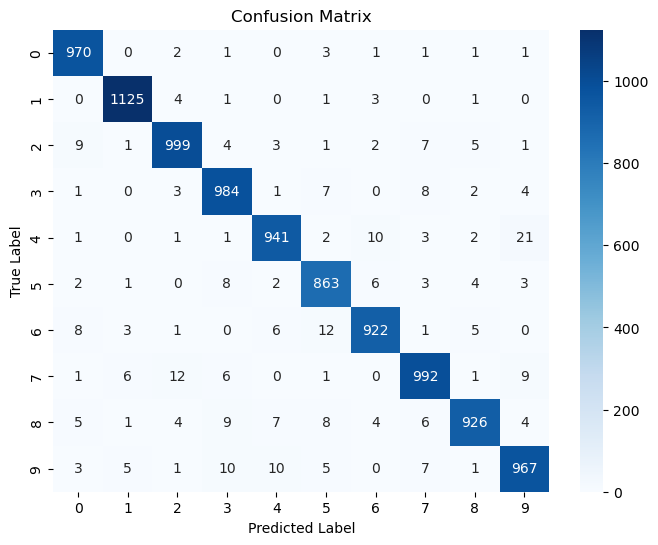

In [58]:
# Get the number of training samples  
N = len(X_train)  

# Initialize a Discriminative RBM (DRBM)
drbm = DRBM(784, 128, 10)  

# Train the DRBM  
drbm.train_drbm(X_train, y_train, n_labeled=N, alpha=0, epochs=10, batch_size=64)  

# Classify test samples given their labels  
drbm.classify_x_given_y(X_test, y_test) 

## Semi-Supervised Learning with DRBM: Varying α Values

This experiment trains the **Discriminative Restricted Boltzmann Machine (DRBM)** using different values of **α**, which balances the **discriminative** and **generative** components in training.

### *1. Understanding α in DRBM Training*
- The loss function in DRBM training consists of:
  - **Discriminative Loss**: Cross-entropy loss for classification.
  - **Generative Loss**: Free energy difference from Contrastive Divergence (CD).

$$
\mathcal{L} = \mathcal{L}_{\text{discriminative}} + \alpha \mathcal{L}_{\text{generative}}
$$

- **Effect of α**:
  - **α = 1**: Balanced training with both classification and generative modeling.
  - **α = 0.1**: Primarily discriminative training with a small generative influence.
  - **α = 0.01**: Almost purely discriminative, with minimal generative modeling.
  - **α = 0**: Fully supervised learning, where the DRBM functions purely as a classifier.

### *2. Experiment Setup*
- Train DRBM with **α values of 1, 0.1, and 0.01**.
- Evaluate classification performance using **p(x | y)**.
- Compare test accuracy and classification reports.

### *3. Key Insights*
- **Higher α values** incorporate more generative learning, which can improve robustness with fewer labeled samples.
- **Lower α values** emphasize classification, optimizing for accuracy but potentially reducing generalization.
- Finding an optimal **α** depends on the dataset and the trade-off between generative and discriminative learning.

By training DRBM under different α values, we analyze how the balance between generative and discriminative components affects classification performance.


Training with α = 1 ...
Trainig DRBM:
Epoch 1: Loss= 0.0926 Accuracy = 0.8413
Epoch 2: Loss= 0.0507 Accuracy = 0.9302
Epoch 3: Loss= 0.0441 Accuracy = 0.9452
Epoch 4: Loss= 0.0420 Accuracy = 0.9554
Epoch 5: Loss= 0.0388 Accuracy = 0.9631
Epoch 6: Loss= 0.0348 Accuracy = 0.9686
Epoch 7: Loss= 0.0302 Accuracy = 0.9734
Epoch 8: Loss= 0.0256 Accuracy = 0.9776
Epoch 9: Loss= 0.0213 Accuracy = 0.9810
Epoch 10: Loss= 0.0175 Accuracy = 0.9841

Classifying using p(x | y) for α = 1 ...

 Classification Report:

              precision    recall  f1-score   support

         0.0     0.9680    0.9878    0.9778       980
         1.0     0.9799    0.9894    0.9847      1135
         2.0     0.9661    0.9651    0.9656      1032
         3.0     0.9580    0.9703    0.9641      1010
         4.0     0.9672    0.9613    0.9642       982
         5.0     0.9489    0.9776    0.9630       892
         6.0     0.9777    0.9593    0.9684       958
         7.0     0.9714    0.9572    0.9642      1028
     

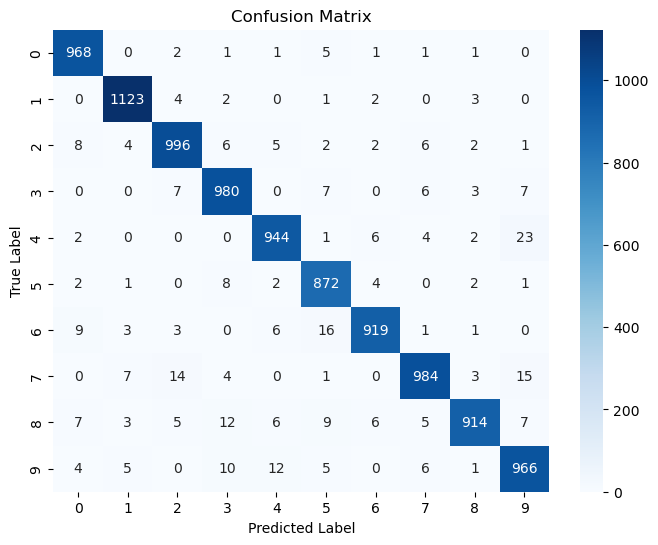


Training with α = 0.1 ...
Trainig DRBM:
Epoch 1: Loss= 0.0915 Accuracy = 0.8425
Epoch 2: Loss= 0.0521 Accuracy = 0.9301
Epoch 3: Loss= 0.0426 Accuracy = 0.9445
Epoch 4: Loss= 0.0385 Accuracy = 0.9545
Epoch 5: Loss= 0.0353 Accuracy = 0.9618
Epoch 6: Loss= 0.0317 Accuracy = 0.9681
Epoch 7: Loss= 0.0276 Accuracy = 0.9729
Epoch 8: Loss= 0.0232 Accuracy = 0.9774
Epoch 9: Loss= 0.0191 Accuracy = 0.9810
Epoch 10: Loss= 0.0156 Accuracy = 0.9837

Classifying using p(x | y) for α = 0.1 ...

 Classification Report:

              precision    recall  f1-score   support

         0.0     0.9669    0.9847    0.9757       980
         1.0     0.9834    0.9903    0.9868      1135
         2.0     0.9737    0.9690    0.9713      1032
         3.0     0.9556    0.9802    0.9677      1010
         4.0     0.9722    0.9613    0.9667       982
         5.0     0.9502    0.9630    0.9566       892
         6.0     0.9694    0.9603    0.9649       958
         7.0     0.9697    0.9640    0.9668      1028
 

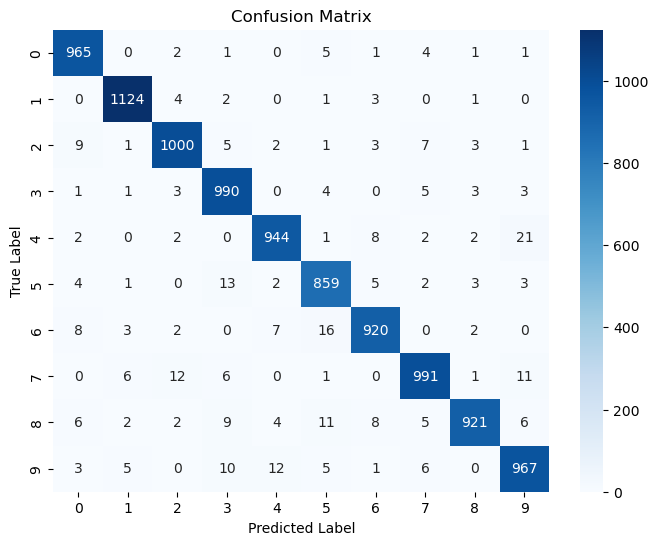


Training with α = 0.01 ...
Trainig DRBM:
Epoch 1: Loss= 0.0993 Accuracy = 0.8436
Epoch 2: Loss= 0.0588 Accuracy = 0.9293
Epoch 3: Loss= 0.0436 Accuracy = 0.9441
Epoch 4: Loss= 0.0340 Accuracy = 0.9546
Epoch 5: Loss= 0.0268 Accuracy = 0.9625
Epoch 6: Loss= 0.0210 Accuracy = 0.9691
Epoch 7: Loss= 0.0167 Accuracy = 0.9740
Epoch 8: Loss= 0.0135 Accuracy = 0.9784
Epoch 9: Loss= 0.0111 Accuracy = 0.9818
Epoch 10: Loss= 0.0093 Accuracy = 0.9852

Classifying using p(x | y) for α = 0.01 ...

 Classification Report:

              precision    recall  f1-score   support

         0.0     0.9748    0.9867    0.9807       980
         1.0     0.9800    0.9912    0.9855      1135
         2.0     0.9728    0.9719    0.9724      1032
         3.0     0.9638    0.9743    0.9690      1010
         4.0     0.9713    0.9644    0.9678       982
         5.0     0.9473    0.9675    0.9573       892
         6.0     0.9766    0.9603    0.9684       958
         7.0     0.9687    0.9630    0.9659      1028

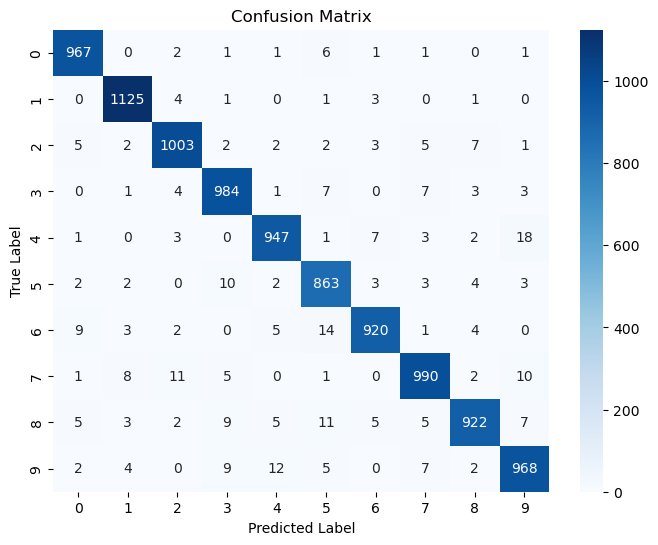

In [60]:
# Run training with different alpha values
alphas = [1, 0.1, 0.01]
for alpha in alphas:
    print(f"\nTraining with α = {alpha} ...")
    drbm = DRBM(784, 128, 10)   # Initialize a new DRBM for each setting
    drbm.train_drbm(X_train, y_train, n_labeled=N, alpha=alpha, epochs=10, batch_size=64)
    print(f"\nClassifying using p(x | y) for α = {alpha} ...")
    drbm.classify_x_given_y(X_test, y_test)

## Semi-Supervised Training of Discriminative Restricted Boltzmann Machine (DRBM)

This experiment evaluates the performance of a **Discriminative Restricted Boltzmann Machine (DRBM)** under different levels of labeled data in a **semi-supervised learning** setting.
### **Training Setup**
#### *1. Labeled Data Variations*
We train the DRBM with different amounts of labeled data:
- **Fully Supervised**: \( N \) labeled samples (all data is labeled).
- **Semi-Supervised**: \( 0.1N \) labeled samples (10% labeled, 90% unlabeled).
- **Highly Semi-Supervised**: \( 0.01N \) labeled samples (only 1% labeled).

#### *2. Training Approach*
- The model combines:
  - **Discriminative loss**: 
    $$
    L_{\text{discriminative}} = -\sum_{i} \log p(y_i | x_i)
    $$
  - **Generative loss** (via Contrastive Divergence): 
    $$
    L_{\text{generative}} = \mathbb{E}_{x \sim p_{\text{data}}} F(x, y) - \mathbb{E}_{x \sim p_{\text{model}}} F(x, y)
    $$
  - The final loss is a weighted sum:
    $$
    L = L_{\text{discriminative}} + \alpha L_{\text{generative}}
    $$
  - Hyperparameter $ \alpha = 0.1 $ controls the influence of unlabeled data.

#### *3. Classification Evaluation*
- After training, the model classifies test samples using:
  $$
  p(y | x) = \frac{e^{-F(x, y)}}{\sum_{y'} e^{-F(x, y')}}
  $$
- A **classification report and confusion matrix** are used for analysis.

### *Expected Outcomes*
- **Fully supervised training** (\( N \) labeled) provides a strong **baseline**.
- **Semi-supervised training** (\( 0.1N \), \( 0.01N \)) improves performance when labeled data is scarce by leveraging **unlabeled data** through generative modeling.


Training with 60000 labeled samples (semi-supervised)...
Trainig DRBM:
Epoch 1: Loss= 0.0856 Accuracy = 0.8427
Epoch 2: Loss= 0.0467 Accuracy = 0.9294
Epoch 3: Loss= 0.0364 Accuracy = 0.9448
Epoch 4: Loss= 0.0300 Accuracy = 0.9558
Epoch 5: Loss= 0.0249 Accuracy = 0.9639
Epoch 6: Loss= 0.0206 Accuracy = 0.9699
Epoch 7: Loss= 0.0172 Accuracy = 0.9746
Epoch 8: Loss= 0.0145 Accuracy = 0.9788
Epoch 9: Loss= 0.0123 Accuracy = 0.9823
Epoch 10: Loss= 0.0106 Accuracy = 0.9854

Classifying using p(x | y)...

 Classification Report:

              precision    recall  f1-score   support

         0.0     0.9691    0.9918    0.9803       980
         1.0     0.9783    0.9921    0.9851      1135
         2.0     0.9708    0.9671    0.9689      1032
         3.0     0.9647    0.9733    0.9690      1010
         4.0     0.9713    0.9633    0.9673       982
         5.0     0.9486    0.9731    0.9607       892
         6.0     0.9766    0.9603    0.9684       958
         7.0     0.9696    0.9611    

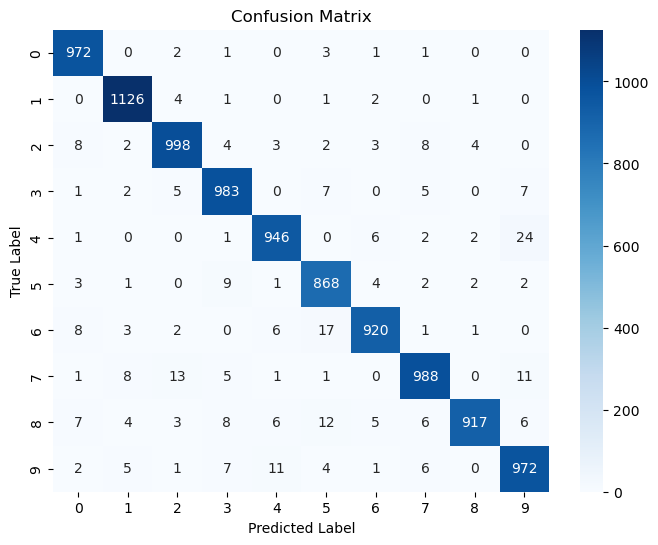


Training with 6000 labeled samples (semi-supervised)...
Trainig DRBM:
Epoch 1: Loss= -2.2231 Accuracy = 0.1152
Epoch 2: Loss= -3.6081 Accuracy = 0.3237
Epoch 3: Loss= -3.9872 Accuracy = 0.5732
Epoch 4: Loss= -4.3153 Accuracy = 0.6910
Epoch 5: Loss= -4.7356 Accuracy = 0.7515
Epoch 6: Loss= -4.5506 Accuracy = 0.7867
Epoch 7: Loss= -4.6300 Accuracy = 0.8103
Epoch 8: Loss= -5.1639 Accuracy = 0.8298
Epoch 9: Loss= -4.8581 Accuracy = 0.8468
Epoch 10: Loss= -5.3272 Accuracy = 0.8595

Classifying using p(x | y)...

 Classification Report:

              precision    recall  f1-score   support

         0.0     0.8714    0.9469    0.9076       980
         1.0     0.9235    0.9683    0.9454      1135
         2.0     0.8937    0.8634    0.8783      1032
         3.0     0.8325    0.8713    0.8515      1010
         4.0     0.8583    0.8635    0.8609       982
         5.0     0.8280    0.7231    0.7720       892
         6.0     0.8854    0.9029    0.8941       958
         7.0     0.8804    0

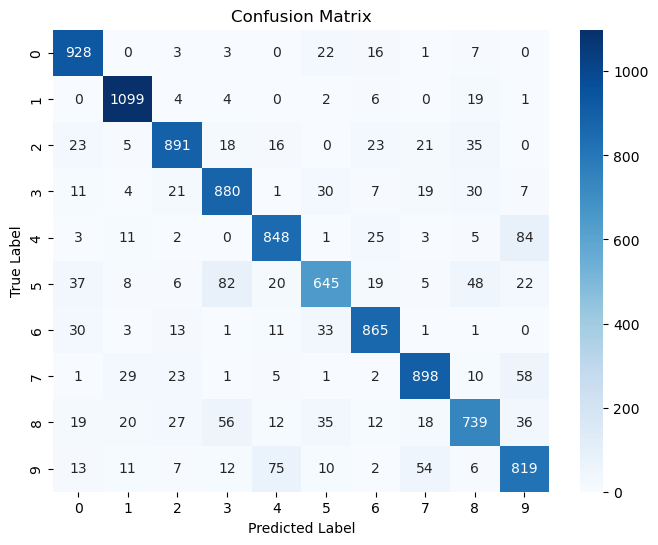


Training with 600 labeled samples (semi-supervised)...
Trainig DRBM:
Epoch 1: Loss= -4.0811 Accuracy = 0.1083
Epoch 2: Loss= -5.7226 Accuracy = 0.1317
Epoch 3: Loss= -4.1213 Accuracy = 0.1367
Epoch 4: Loss= -4.2975 Accuracy = 0.1350
Epoch 5: Loss= -2.7562 Accuracy = 0.1317
Epoch 6: Loss= -2.7470 Accuracy = 0.1317
Epoch 7: Loss= -2.7333 Accuracy = 0.1317
Epoch 8: Loss= -2.5296 Accuracy = 0.1317
Epoch 9: Loss= -2.4142 Accuracy = 0.1317
Epoch 10: Loss= -2.1111 Accuracy = 0.1317

Classifying using p(x | y)...

 Classification Report:

              precision    recall  f1-score   support

         0.0     1.0000    0.0031    0.0061       980
         1.0     0.1140    1.0000    0.2047      1135
         2.0     0.1500    0.0058    0.0112      1032
         3.0     0.0000    0.0000    0.0000      1010
         4.0     0.0000    0.0000    0.0000       982
         5.0     0.0000    0.0000    0.0000       892
         6.0     0.0000    0.0000    0.0000       958
         7.0     0.0000    0.

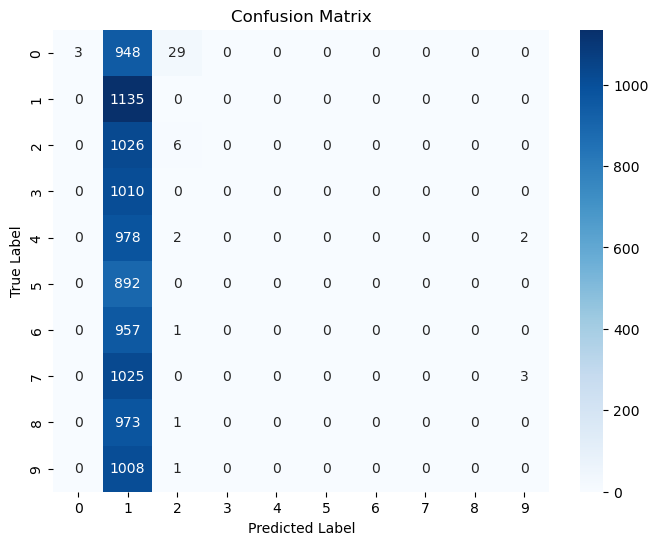

In [57]:
# Run training for different n values
n_values = [N, int(0.1 * N), int(0.01 * N)]

for n_labeled in n_values:
    print(f"\nTraining with {n_labeled} labeled samples (semi-supervised)...")
    drbm = DRBM(784, 128, 10)   # Initialize a new DRBM for each setting
    drbm.train_drbm(X_train, y_train, n_labeled= n_labeled, alpha=0.1, epochs=10, batch_size=64)
    print("\nClassifying using p(x | y)...")
    drbm.classify_x_given_y(X_test, y_test) # Classify test samples using p(x | y)